In [76]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
import numpy as np
import ray
import os
import optuna 

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
df = pd.read_csv("aquatics-ARIK-oxygen-Predicted.csv")

In [2]:
df.head()

,datetime,.pred,oxygen,air_temperature,surface_downwelling_longwave_flux_in_air,surface_downwelling_shortwave_flux_in_air,precipitation_flux,air_pressure,relative_humidity,northward_wind,eastward_wind
0,2020-11-02,6.526266,6.119156,13.359830,272.077880,162.629032,0.0,88821.367692,0.309830,2.668139,0.257750
1,2020-11-03,6.075640,5.877618,16.389842,278.678338,158.225806,0.0,88163.690199,0.241677,2.488065,1.287034
2,2020-11-04,5.625103,5.172174,18.337971,304.047355,151.000000,0.0,88007.810631,0.242501,3.420230,-2.225313
3,2020-11-05,5.607800,5.053873,16.067992,282.212475,153.540323,0.0,88587.113575,0.278865,1.365854,-0.820159
4,2020-11-06,5.341532,5.348101,17.385899,280.930195,143.596774,0.0,87818.473118,0.250312,1.305135,6.879596


In [3]:
import pandas as pd
from darts.models import GaussianProcessFilter
from darts import TimeSeries
from sklearn.gaussian_process.kernels import RBF
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import LaplaceLikelihood
from darts.dataprocessing.transformers import Scaler
import ray

def make_stitched_series(variable_tseries):
    """
    Returns a dictionary {"variable": stitched time series of variable}
    """
    kernel = RBF()
    
    gpf_missing = GaussianProcessFilter(kernel=kernel, 
                                        alpha=0.001, 
                                        n_restarts_optimizer=100)
    
    gpf_missing_big_gaps = GaussianProcessFilter(kernel=kernel, 
                                                 alpha=2, 
                                                 n_restarts_optimizer=10)
    stitched_series = {}

    # Filtering the TimeSeries
    try:
        filtered = gpf_missing.filter(variable_tseries, num_samples=500)
        filtered_big_gaps = gpf_missing_big_gaps.filter(variable_tseries, 
                                                        num_samples=500)
    except:
        return None

    #if there is a gap over 7 indices, use big gap filter
    gap_series = variable_tseries.gaps()
    stitched_df = filtered.pd_dataframe()
    replacement_df = filtered_big_gaps.pd_dataframe()
    
    for index, row in gap_series.iterrows():
        if row["gap_size"] > 7:
            for date in pd.date_range(row["gap_start"], row["gap_end"]):
                stitched_df.loc[date] = replacement_df.loc[date]
    
    stitched_series = TimeSeries.from_times_and_values(
                                stitched_df.index, 
                                stitched_df.values.reshape(
                                            len(stitched_df), 
                                            1, 
                                            -1))
    
    return stitched_series

In [4]:
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
oxy_tseries = TimeSeries.from_times_and_values(times, df["oxygen"], fill_missing_dates=True, freq="D")
predictions_tseries = TimeSeries.from_times_and_values(times, df[".pred"], fill_missing_dates=True, freq="D")

In [5]:
covs_dict = {}
for cov in df.columns[3:]:
    covs_dict[cov] = TimeSeries.from_times_and_values(times, df[cov], fill_missing_dates=True, freq="D")

In [6]:
def make_cov_plot(cov, covs_dict):
    plt.clf()
    covs_dict[cov].plot(label=f"{cov}")
    plt.show()

In [7]:
filtered_covs_dict = {}
predictions_filtered = make_stitched_series(predictions_tseries)
oxy_tseries_filtered = make_stitched_series(oxy_tseries)
for key in covs_dict.keys():
    filtered_covs_dict[key] = make_stitched_series(covs_dict[key])

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [8]:
covs_dict.keys()

dict_keys(['air_temperature', 'surface_downwelling_longwave_flux_in_air', 'surface_downwelling_shortwave_flux_in_air', 'precipitation_flux', 'air_pressure', 'relative_humidity', 'northward_wind', 'eastward_wind'])

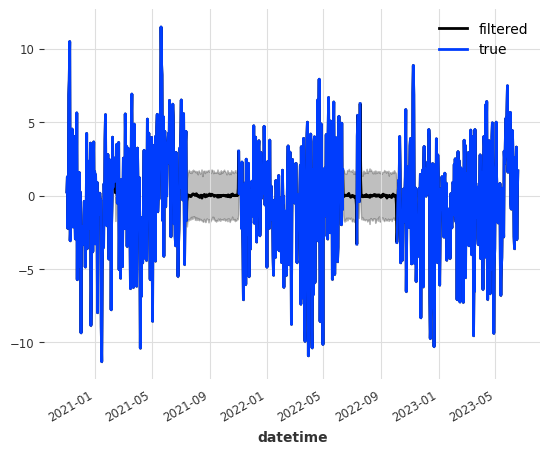

In [9]:
plt.clf()
filtered_covs_dict["eastward_wind"].plot(label="filtered")
covs_dict["eastward_wind"].plot(label="true")
plt.show()

In [78]:
inputs = predictions_filtered-oxy_tseries_filtered
# For covariates here we have [predictions, observed oxygen, air temperature]
covs = predictions_filtered.concatenate(oxy_tseries_filtered, axis=1, ignore_time_axis=True)
covs = covs.concatenate(filtered_covs_dict["air_temperature"], axis=1, ignore_time_axis=True)

val_split = pd.Timestamp(year=2023, month=6, day=18)
training_set, validation_set = inputs.split_before(val_split)

In [26]:
import time
start = time.time()
rnn = BlockRNNModel(model="LSTM",
                    hidden_dim=256,
                    batch_size=8,
                    input_chunk_length=15,
                    output_chunk_length=34,
                    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
                    optimizer_kwargs={"lr": 1e-4},
                    n_rnn_layers=3,
                    random_state=0)
    
rnn.fit(training_set,
        past_covariates=covs,
        epochs=500, 
        verbose=False)
print(time.time()-start)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.


682.7718353271484


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

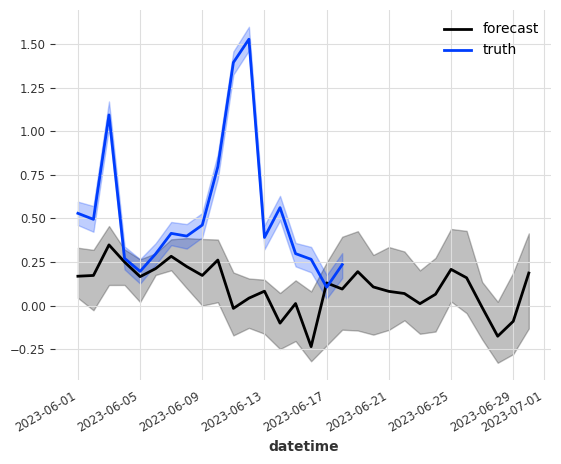

In [27]:
plt.clf()
preds = rnn.predict(n=30,
                    past_covariates=covs, 
                    num_samples=50)
preds.plot(label="forecast")
validation_set.plot(label="truth")
plt.show()

In [80]:
from darts.models import TCNModel
start = time.time()
tcn = TCNModel(input_chunk_length=35,
               output_chunk_length=34,
               likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
               random_state=0)
    
tcn.fit(training_set,
        past_covariates=covs,
        epochs=500, 
        verbose=False)
print(time.time()-start)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.


92.09227752685547


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

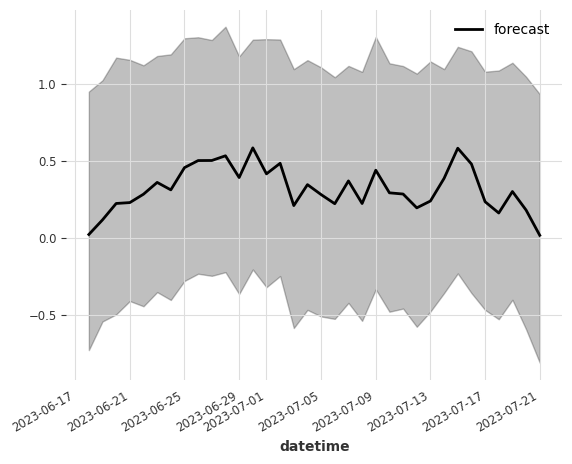

In [81]:
plt.clf()
preds = tcn.predict(n=34,
                    past_covariates=covs, 
                    num_samples=500)
preds.plot(label="forecast")
#validation_set.plot(label="truth")
plt.show()

In [85]:
preds.pd_dataframe().to_csv("predicted_residuals_2023_06_21")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [45]:
val_split = pd.Timestamp(year=2023, month=6, day=1)
_, oxy_val = oxy_tseries_filtered.split_before(val_split)
_, predictions_val = predictions_filtered.split_before(val_split)

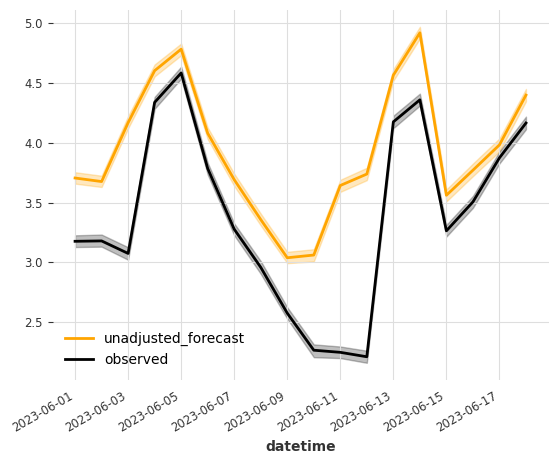

In [60]:
plt.clf()
predictions_val.plot(color="orange", label="unadjusted_forecast")
#(predictions_val-preds[:18]).plot(color="blue", label="adjusted_forecast")
oxy_val.plot(color="black", label="observed")
plt.show()

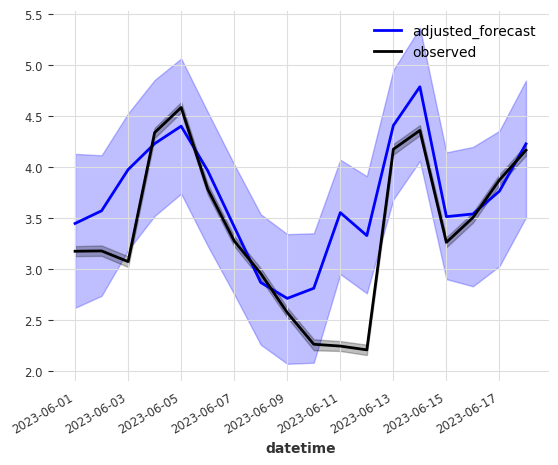

In [61]:
plt.clf()
(predictions_val-preds[:18]).plot(color="blue", label="adjusted_forecast")
oxy_val.plot(color="black", label="observed")
plt.show()

In [74]:
from optuna.integration import PyTorchLightningPruningCallback
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # Hyperparameters
    input_chunk_length = trial.suggest_categorical("input_chunk_length", [7, 30, 60, 180, 356])
    kernel_size = trial.suggest_categorical("kernel_size", [1, 3, 5])
    num_filters = trial.suggest_categorical("num_filters", [1, 3, 5])
    num_layers = trial.suggest_categorical("num_layers", [1, 2, 3])
    dilation_base = trial.suggest_categorical("dilation_base", [1, 2, 3])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])

    tcn_model = TCNModel(input_chunk_length=input_chunk_length,
                    kernel_size=kernel_size,
                    num_filters=num_filters,
                    output_chunk_length=30,
                    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]))

    tcn_model.fit(training_set,
                  past_covariates=covs,
                  epochs=400, 
                  verbose=False)

    predictions = tcn_model.predict(n=len(validation_set), 
                                    past_covariates=covs, 
                                    num_samples=50)
    smapes = smape(validation_set, predictions, n_jobs=-1, verbose=False)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

In [75]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2023-06-22 16:45:01,523] A new study created in memory with name: no-name-36334021-cbed-45b1-852c-aac3dc90b11e
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

[W 2023-06-22 16:46:20,198] Trial 0 failed with parameters: {'input_chunk_length': 180, 'kernel_size': 3, 'num_filters': 5, 'num_layers': 3, 'dilation_base': 1, 'dropout': 0.1} because of the following error: NameError("name 'np' is not defined").
Traceback (most recent call last):
  File "/home/rstudio/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1801703/503127739.py", line 28, in objective
    smape_val = np.mean(smapes)
NameError: name 'np' is not defined
[W 2023-06-22 16:46:20,199] Trial 0 failed with value None.


NameError: name 'np' is not defined

In [ ]:
#2023-06-21 for 31 days

In [ ]:
#Pathways: extending this as a tool that anyone can use; 
# comparing this to using probabilistic model on the initial time series